In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt  # standard Python plotting library
from scipy.signal import find_peaks, peak_prominences, peak_widths
# import the tdt library
import tdt
import pandas as pd
import seaborn as sns
from sklearn.metrics import auc
import scipy.stats as stats
import glob

In [6]:
blockpath = r"c:\Users\aak283\Fiber_Photo\Tanks\RI60 Day 8 tanks\het\EN140_RI60D8-240727-140607" 
 # created a dictionary to read
isosbestic = '_415A'
dopa = '_465A'
RNP = 'RNP_'
RMG = 'RMG_'
URM = 'URM_'
STREAM_STORE = '_465A'   #seems to be having trouble finding this later on?
ARTIFACT     = np.inf       # optionally set an artifact rejection level (figure out what this actually does)
CHANNEL      = 1
TRANGE       = [-5, 10]  # window size [start time relative to epoc onset, window duration]


In [7]:
def readfiles(blockpath):
    data = tdt.read_block(blockpath)
    time = np.linspace(1,len(data.streams[dopa].data), len(data.streams[dopa].data))/data.streams[dopa].fs
    t = 5
    inds = np.where(time>t)
    ind = inds[0][0]
    time = time[ind:] # go from ind to final index
    data.streams[dopa].data = data.streams[dopa].data[ind:]
    data.streams[isosbestic].data = data.streams[isosbestic].data[ind:]
    N = 10 # Average every 10 samples into 1 value
    F415 = []
    F465 = []
    DSFactor = (data.streams[dopa].fs)/N

    for i in range(0, len(data.streams[dopa].data), N):
        F465.append(np.mean(data.streams[dopa].data[i:i+N-1])) # This is the moving window mean
    data.streams[dopa].data = F465

    for i in range(0, len(data.streams[isosbestic].data), N):
        F415.append(np.mean(data.streams[isosbestic].data[i:i+N-1]))
    data.streams[isosbestic].data = F415

    #decimate time array to match length of demodulated stream
    time = time[::N] # go from beginning to end of array in steps on N
    time = time[:len(data.streams[dopa].data)]

    x = np.array(data.streams[isosbestic].data)
    y = np.array(data.streams[dopa].data)
    bls = np.polyfit(x, y, 1)
    Y_fit_all = np.multiply(bls[0], x) + bls[1]
    Y_dF_all = y - Y_fit_all

    dFF = np.multiply(100, np.divide(Y_dF_all, Y_fit_all))
    return data, dFF

In [8]:
hetpath = r"c:\Users\aak283\Fiber_Photo\Tanks\RI60 Day 8 tanks\het/*"
wtpath = r"c:\Users\aak283\Fiber_Photo\Tanks\RI60 Day 8 tanks\wt/*"

In [9]:
het_rmg_streams = []
het_zscores = []
for file in glob.glob(hetpath):
    data, dFF = readfiles(file)
    rmg_ind = []
    for i in range(len(data.epocs.RMG_.onset)):
        rnp_ind = int(101.8*data.epocs.RMG_.onset[i])    
        sliced = dFF[rnp_ind:rnp_ind + int(10*101.8)]
        peaks = find_peaks(sliced, prominence = 3)
        if len(peaks[1]['prominences']) != 0:
            idxmax = np.argmax(peaks[1]['prominences'])
            rmg_ind.append(rnp_ind + int(peaks[0][idxmax]))

    before = -3
    after = 5
    T = np.linspace(before, after, int((after - before)*101.8))
    rmg_streams = []
    for ind in rmg_ind:
        if (int(after*101.8) + ind) < len(dFF):
            rmg_streams.append(dFF[ind + int(before*101.8): ind + int(after*101.8)])
    het_rmg_streams.append(np.mean(rmg_streams, axis = 0))

    BASELINE_PER = [1, 5]
    hzall = []
    for dF in het_rmg_streams: 
        ind = np.where((np.array(T)<BASELINE_PER[1]) & (np.array(T)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        hzall.append((dF - zb)/zsd)
    het_zscores.append(np.mean(hzall, axis= 0))
    

In [10]:
wt_rmg_streams = []
wt_zscores = []
for file in glob.glob(wtpath):
    data, dFF = readfiles(file)
    rmg_ind = []
    for i in range(len(data.epocs.RMG_.onset)):
        rnp_ind = int(101.8*data.epocs.RMG_.onset[i])    
        sliced = dFF[rnp_ind:rnp_ind + int(10*101.8)] # 2-10 seconds after rnp for peak detection
        peaks = find_peaks(sliced, prominence = 3)
        if len(peaks[1]['prominences']) != 0:
            idxmax = np.argmax(peaks[1]['prominences'])
            rmg_ind.append(rnp_ind + int(peaks[0][idxmax]))

    before = -3
    after = 5
    T = np.linspace(before, after, int((after - before)*101.8))
    rmg_streams = []
    for ind in rmg_ind:
        if (ind + int(after*101.8)) < len(dFF):
            rmg_streams.append(dFF[ind + int(before*101.8): ind + int(after*101.8)])
    wt_rmg_streams.append(np.mean(rmg_streams, axis = 0))

    BASELINE_PER = [1, 5]
    wzall = []
    for dF in wt_rmg_streams: 
        ind = np.where((np.array(T)<BASELINE_PER[1]) & (np.array(T)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        wzall.append((dF - zb)/zsd)
    wt_zscores.append(np.mean(wzall, axis= 0))
    

In [273]:
print(len(het_zscores), len(wt_zscores))

9 9


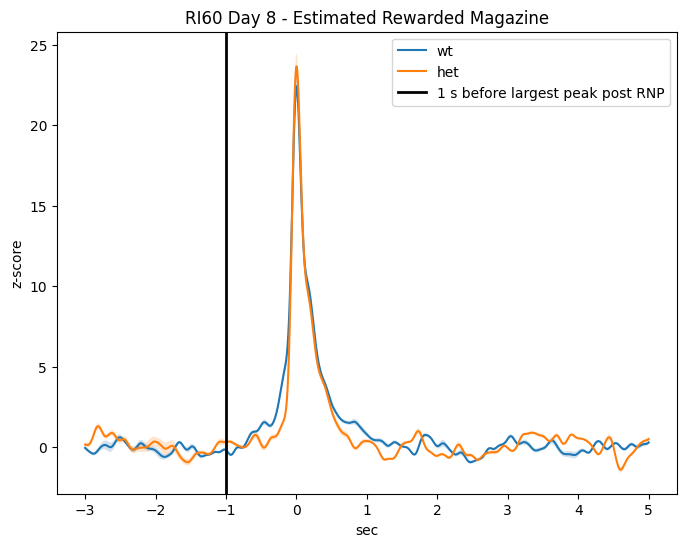

In [293]:
fig0 = plt.figure(figsize = (8,6))
ax = fig0.add_subplot(111)
ax.plot(T, np.mean(wt_zscores, axis = 0), label = 'wt')
ax.plot(T, np.mean(het_zscores, axis = 0), label = 'het')
ax.fill_between(T, np.mean(wt_zscores, axis=0)+(np.std(wt_zscores, axis=0)/np.sqrt(np.size(wt_zscores, axis=0)))
                      ,np.mean(wt_zscores, axis=0)-(np.std(wt_zscores, axis=0)/np.sqrt(np.size(wt_zscores, axis=0))), alpha = .2)
ax.fill_between(T, np.mean(het_zscores, axis=0)+(np.std(het_zscores, axis=0)/np.sqrt(np.size(het_zscores, axis=0)))
                      ,np.mean(het_zscores, axis=0)-(np.std(het_zscores, axis=0)/np.sqrt(np.size(het_zscores, axis=0))), alpha = .2)
ax.axvline(x = -1, linewidth = 2, color = 'black', label = '1 s before largest peak post RNP')
ax.set_ylabel('z-score')
ax.set_xlabel('sec')
ax.set_title('RI60 Day 8 - Estimated Rewarded Magazine')
ax.legend()

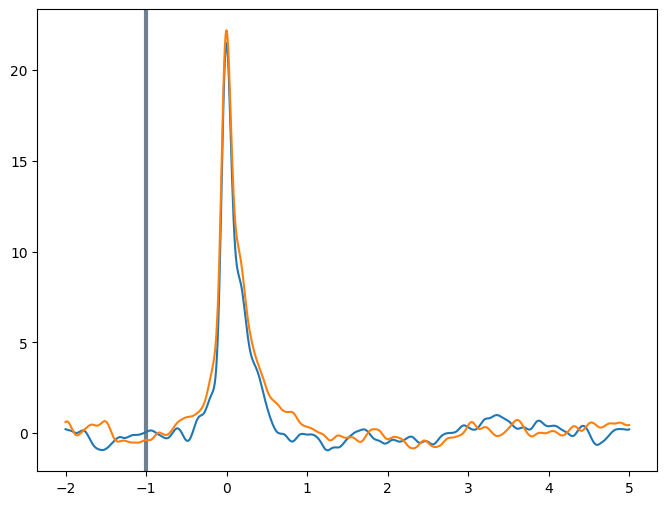

In [243]:
fig1 = plt.figure(figsize=(8,6))
# ax0 = fig1.add_subplot(311)
ax1 = fig1.add_subplot(111)
# p1, = ax0.plot(plotTimed, sliced, linewidth=2, color='green', label='Dopamine')
p2 = ax1.axvline(x=-1, linewidth=3, color='slategray', label='n')
p3 = ax1.plot(T, np.mean(hzall, axis = 0))
p4 = ax1.plot(T, np.mean(wzall, axis = 0))